# Modelling

The goal is to create model that will predict forex-pair value movements

### Plan: 

From the data:
1. Generate sentiment analysis using FinBERT model on a daily basis
2. `groupby()` the days and get the average sentiment 
3. Append the average daily sentiment and import over to another data `final_dataset`
4. `final_dataset` will have columns => `close_price`, `open_price`, `change_in_price`, `date`, `avg_news_sentiment` 
5. Use `Prophet` by Facebook first because its a sci-kit learn based model

Testing: 
1. Remove last week and try to predict this week's prices 

# To improve on news_pipeline 

1. Include sentiment analysis after retrieving data 
2. Change data to datetime 

EURUSD=X modelling

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import scipy

from prophet import Prophet

import yfinance as yf 

## Database Cleaning & Formatting

In [4]:
articles = pd.read_parquet(r"data\raw_scrapped_data\EURUSD=X_fxstreet_database")
print(articles.columns)
print(articles.describe)

Index(['title', 'link', 'date', 'text'], dtype='object')
<bound method NDFrame.describe of                                                 title  \
0   EUR/USD Price Analysis: Euro extends losses bu...   
1   EUR/USD slumps on Eurozone economic risks, Fed...   
2             EUR drifts near range base – Scotiabank   
3   EUR/USD may find good support at its 200-DMA –...   
4   EUR/USD to consolidate in the 1.08-1.09 range ...   
..                                                ...   
9   EUR: Waiting for ECB Monetary Policy Meeting A...   
10        EUR/USD: Expected to edge lower – UOB Group   
11        German Retail Sales rise 2.1% YoY in August   
12  EUR/USD hangs near two-month low, seems vulner...   
13  EUR/USD sees more downside below 1.0950 as ECB...   

                                                 link  \
0   https://www.fxstreet.com/news/eur-usd-price-an...   
1   https://www.fxstreet.com/news/eur-usd-drops-as...   
2   https://www.fxstreet.com/news/eur-drifts-near-...

In [5]:
# Init FinBERT
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [6]:
tokenizer_kwargs = {
    "padding" : True,
    "truncation" : True,
    "max_length" : 512,
}

def analyze_sentiment(x):
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = finbert(**input_sequence).logits
        # Apply softmax to get probabilities 
        prob = scipy.special.softmax(logits.numpy().squeeze())
        weights = {
            0 : -1, # Negative
            1 : 0, # Neutral
            2 : 1 # Positive
        }
        # Calculate polarity score
        polarity = sum(prob[i] * weights[i] for i in range(len(prob)))
    return polarity # Returns raw sentiment scores (as probabilities)

articles['sentiment_polarity'] = articles['text'].apply(analyze_sentiment)

# Ref: 
# https://www.kaggle.com/code/mexwell/huggingface-finbert-for-sentiment-analysis 2025-03-22
# https://medium.com/@ravirajshinde2000/financial-news-sentiment-analysis-using-finbert-25afcc95e65f 2025-03-22


In [7]:
display(articles)

,title,link,date,text,sentiment_polarity
0,EUR/USD Price Analysis: Euro extends losses bu...,https://www.fxstreet.com/news/eur-usd-price-an...,03/21/2025 15:50:00 GMT,The Relative Strength Index (RSI) has sharply ...,0.802290
1,"EUR/USD slumps on Eurozone economic risks, Fed...",https://www.fxstreet.com/news/eur-usd-drops-as...,03/21/2025 14:39:04 GMT,Powell commented that the implementation of ne...,0.475871
2,EUR drifts near range base – Scotiabank,https://www.fxstreet.com/news/eur-drifts-near-...,03/21/2025 13:23:43 GMT,Spot continues to consolidate in the low 1.08s...,0.807000
3,EUR/USD may find good support at its 200-DMA –...,https://www.fxstreet.com/news/eur-usd-may-find...,03/21/2025 11:36:45 GMT,"EUR/USD remains heavy near this week’s lows, B...",0.849698
4,EUR/USD to consolidate in the 1.08-1.09 range ...,https://www.fxstreet.com/news/eur-usd-to-conso...,03/21/2025 10:28:54 GMT,"EUR/USD fell below 1.09 yesterday, Danske Bank...",0.577696
...,...,...,...,...,...
9,EUR: Waiting for ECB Monetary Policy Meeting A...,https://www.fxstreet.com/news/eur-waiting-for-...,10/10/2024 08:49:00 GMT,“Hence the market is now fully pricing 25bp ra...,0.848228
10,EUR/USD: Expected to edge lower – UOB Group,https://www.fxstreet.com/news/eur-usd-expected...,10/10/2024 08:24:54 GMT,24-HOUR VIEW: “We expected EUR to trade in a s...,0.314616
11,German Retail Sales rise 2.1% YoY in August,https://www.fxstreet.com/news/german-retail-sa...,10/10/2024 06:05:00 GMT,Germany's Retail Sales increased by 1.6% MoM i...,0.862127
12,"EUR/USD hangs near two-month low, seems vulner...",https://www.fxstreet.com/news/eur-usd-hangs-ne...,10/10/2024 01:00:48 GMT,The EUR/USD pair oscillates in a narrow band b...,0.797750


Now we also need to convert all the `date` rows into datetime objs

In [8]:
def convert_to_datetime(date_str):
    date_format = "%m/%d/%Y %H:%M:%S GMT"
    return datetime.strptime(date_str, date_format)


In [9]:
articles['date'] = articles['date'].apply(convert_to_datetime) # Override! 

In [10]:
display(articles)

,title,link,date,text,sentiment_polarity
0,EUR/USD Price Analysis: Euro extends losses bu...,https://www.fxstreet.com/news/eur-usd-price-an...,2025-03-21 15:50:00,The Relative Strength Index (RSI) has sharply ...,0.802290
1,"EUR/USD slumps on Eurozone economic risks, Fed...",https://www.fxstreet.com/news/eur-usd-drops-as...,2025-03-21 14:39:04,Powell commented that the implementation of ne...,0.475871
2,EUR drifts near range base – Scotiabank,https://www.fxstreet.com/news/eur-drifts-near-...,2025-03-21 13:23:43,Spot continues to consolidate in the low 1.08s...,0.807000
3,EUR/USD may find good support at its 200-DMA –...,https://www.fxstreet.com/news/eur-usd-may-find...,2025-03-21 11:36:45,"EUR/USD remains heavy near this week’s lows, B...",0.849698
4,EUR/USD to consolidate in the 1.08-1.09 range ...,https://www.fxstreet.com/news/eur-usd-to-conso...,2025-03-21 10:28:54,"EUR/USD fell below 1.09 yesterday, Danske Bank...",0.577696
...,...,...,...,...,...
9,EUR: Waiting for ECB Monetary Policy Meeting A...,https://www.fxstreet.com/news/eur-waiting-for-...,2024-10-10 08:49:00,“Hence the market is now fully pricing 25bp ra...,0.848228
10,EUR/USD: Expected to edge lower – UOB Group,https://www.fxstreet.com/news/eur-usd-expected...,2024-10-10 08:24:54,24-HOUR VIEW: “We expected EUR to trade in a s...,0.314616
11,German Retail Sales rise 2.1% YoY in August,https://www.fxstreet.com/news/german-retail-sa...,2024-10-10 06:05:00,Germany's Retail Sales increased by 1.6% MoM i...,0.862127
12,"EUR/USD hangs near two-month low, seems vulner...",https://www.fxstreet.com/news/eur-usd-hangs-ne...,2024-10-10 01:00:48,The EUR/USD pair oscillates in a narrow band b...,0.797750


Now we need to append the price of the ticker to the closest timestamp as to when the article was published.

In [11]:
# Create a ticker for all currency pairs
EURUSD = yf.Ticker("EURUSD=X") # EUR/USD
USDJPY = yf.Ticker("JPY=X")
GBPUSD = yf.Ticker("GBPUSD=X")

def find_ticker_val(day):
    following_hour = day + timedelta(hours=2)
    ticker_data = EURUSD.history(start=day, end=following_hour, interval="1h").reset_index()
    print(ticker_data)
    # NOTE: we are limited to get only hours
    # We'll get the average within the hour (so first two columns)
    try: 
        ticker_val = np.average([ticker_data.iloc[0,1], ticker_data.iloc[1,1]]) # We'll reference "Open" just because, and we'll get the average within the hour
    except: 
        # If for some reason an error occurs, then go backwards an hour
        try: 
            previous_day = day - timedelta(days=1)
            ticker_data = EURUSD.history(start=previous_day, end=day, interval="1h").reset_index()
            ticker_val = np.average([ticker_data.iloc[-1,1], ticker_data.iloc[-2,1]])     
        except:
            try: 
                # If for some reason, the handle ALSO throws an error...
                previous_second_day = day - timedelta(days=2)
                ticker_data = EURUSD.history(start=previous_second_day, end=previous_day, interval="1h").reset_index()
                display(ticker_data)
                ticker_val = np.average([ticker_data.iloc[-1,1], ticker_data.iloc[-2,1]])   
            except: 
                # We are not going 3 days behind, so just produce None and we will get rid of this data
                ticker_val = None
    return ticker_val
 
print(find_ticker_val(datetime.strptime("2025-02-22 23:16:41", "%Y-%m-%d %H:%M:%S")))

# Ref: 
# https://stackoverflow.com/questions/6871016/adding-days-to-a-date-in-python 2025-03-23

$EURUSD=X: possibly delisted; no price data found  (1h 2025-02-22 23:16:41 -> 2025-02-23 01:16:41)
$EURUSD=X: possibly delisted; no price data found  (1h 2025-02-21 23:16:41 -> 2025-02-22 23:16:41)


Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-02-20 23:00:00+00:00,1.050420,1.050751,1.050310,1.050310,0,0.0,0.0
1,2025-02-21 00:00:00+00:00,1.050310,1.050310,1.049208,1.049318,0,0.0,0.0
2,2025-02-21 01:00:00+00:00,1.049208,1.049538,1.048768,1.048988,0,0.0,0.0
3,2025-02-21 02:00:00+00:00,1.048988,1.050531,1.048878,1.050531,0,0.0,0.0
4,2025-02-21 03:00:00+00:00,1.050531,1.050641,1.050310,1.050531,0,0.0,0.0
5,2025-02-21 04:00:00+00:00,1.050420,1.050751,1.050089,1.050200,0,0.0,0.0
6,2025-02-21 05:00:00+00:00,1.050310,1.050310,1.049538,1.049648,0,0.0,0.0
7,2025-02-21 06:00:00+00:00,1.049538,1.049648,1.049098,1.049208,0,0.0,0.0
8,2025-02-21 07:00:00+00:00,1.049318,1.050200,1.049318,1.049538,0,0.0,0.0
9,2025-02-21 08:00:00+00:00,1.049428,1.049648,1.047120,1.047889,0,0.0,0.0


1.0462987422943115


*Optimize*

The thing about this function is that it averages throughout the whole hour. We could have done something similar to; 

If less than 30 mins the hour, get to the starting hour 
If more than 30 mins to the hour

In [ ]:
articles['ticker_val'] = articles['date'].apply(find_ticker_val);

Found to have lots of errors so I had to modify `find_ticker_val()` function to have a try and error catching. One of the errors were that on Weekends, stock market prices were not tracked thus no records. If `following_day` were to land on a Saturday, it would through an error.

Another is that days not within the market or have not been saved yet. Cases within days `2025-03-22` and onwards. We'll have to find a way: 

1. Safe keep the data (massive storage for all the articles) 
2. Find ticker values if possible
3. Remove NaNs 
4. Append to final modelling dataset. 

Then: 

1. For each article that is not in the final modelling dataset, try to find the `ticker_val` again. (Will incur compute costs though so we'll iterate through the lists) 
2. Append into final modelling dataset.

In [14]:
# Save this data 
file_name = "EURUSD-modelling-database.parquet"
articles.to_parquet(f"data\modelling_dataset\{file_name}")

<string>:3: SyntaxWarning: invalid escape sequence '\{'
<>:3: SyntaxWarning: invalid escape sequence '\{'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<string>:3: SyntaxWarning: invalid escape sequence '\{'
<>:3: SyntaxWarning: invalid escape sequence '\{'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\sumag\AppData\Local\Temp\ipykernel_30264\2673398507.py:3: SyntaxWarning: invalid escape sequence '\{'
  articles.to_parquet(f"data\modelling_dataset\{file_name}")
C:\Users\sumag\AppData\Local\Temp\ipykernel_30264\2673398507.py:3: SyntaxWarning: invalid escape sequence '\m'
  articles.to_parquet(f"data\modelling_dataset\{file_name}")


## Modelling

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

import os 
from datetime import datetime

import plotly.express as px
from plotly.subplots import make_subplots

Using this tutorial: https://youtu.be/94PlBzgeq90?si=rhcKPOj8b7IyCx7a, to build the model

In [2]:
data = pd.read_parquet("data\modelling_dataset\EURUSD-modelling-database.parquet");
data = data.drop(columns=['title','link','text'])
data = data.dropna()
print(f"Number of articles: {len(data)}")
print(data.info())
# print(data.describe())

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\sumag\AppData\Local\Temp\ipykernel_14876\613577861.py:1: SyntaxWarning: invalid escape sequence '\m'
  data = pd.read_parquet("data\modelling_dataset\EURUSD-modelling-database.parquet");


Number of articles: 965
<class 'pandas.core.frame.DataFrame'>
Index: 965 entries, 0 to 13
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                965 non-null    datetime64[ns]
 1   sentiment_polarity  965 non-null    float64       
 2   ticker_val          965 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 30.2 KB
None


In [3]:
data.head()

,date,sentiment_polarity,ticker_val
0,2025-03-21 15:50:00,0.802290,1.081959
1,2025-03-21 14:39:04,0.475871,1.083248
2,2025-03-21 13:23:43,0.807000,1.083482
3,2025-03-21 11:36:45,0.849698,1.084775
4,2025-03-21 10:28:54,0.577696,1.083600


Aggregate the data per Day 

Intial Data Visualization

In [4]:
subfig = make_subplots(specs=[[{"secondary_y": True}]])

ticker_fig = px.line(
    y = data['ticker_val'],
    x = data['date']
)
sentiment_fig = px.line(
    y = data['sentiment_polarity'],
    x = data['date'],
)

ticker_fig.update_traces(
    yaxis = "y2",
    line_color="red"
)

subfig.add_traces(ticker_fig.data + sentiment_fig.data)
subfig.show()

# Modelling Using LSTM

In [ ]:
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler

Using sliding window approach 

In [38]:
# Ensuring the data is sorted by date
data = data.sort_values('date')

# Drop 'date' from features (use time steps instead)
features = data[['sentiment_polarity','ticker_val']].values # Include ticker as input feature

# Normalize both features and target
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

Function to generate input-output pairs for time series.

In [39]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :]) # All features as input
        y.append(data[i+window_size, 1]) # Predict next `ticker_val` (column index 1)
    return np.array(X), np.array(y)

WINDOW_SIZE = 5 # Use past work-week to predict the next day's value 

X, y = create_sequences(scaled_data, WINDOW_SIZE)

Train-test split!

In [40]:
cutoff_date = datetime(month=3, day=16, year=2025)

cutoff_idx = data[data['date'] > cutoff_date].index[0] - WINDOW_SIZE

X_train, y_train = X[:cutoff_idx], y[:cutoff_idx]
X_test, y_test = X[cutoff_idx:], y[cutoff_idx]

Adjust the input shape to match the 3D structure of your data

In [42]:
model = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, X_train.shape[2])),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', 
              loss='mae',
              metrics=[keras.metrics.RootMeanSquaredError()
                      ])
model.summary()

C:\Users\sumag\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 5, 64)          │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,625 (229.00 KB)

 Trainable params: 58,625 (229.00 KB)

 Non-trainable params: 0 (0.00 B)

Training the model

In [44]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.7505 - root_mean_squared_error: 1.7509 - val_loss: 1.6049 - val_root_mean_squared_error: 1.6049
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 1.7094 - root_mean_squared_error: 1.7095 - val_loss: 1.5673 - val_root_mean_squared_error: 1.5673
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 1.6852 - root_mean_squared_error: 1.6860 - val_loss: 1.5293 - val_root_mean_squared_error: 1.5293
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 1.6305 - root_mean_squared_error: 1.6307 - val_loss: 1.4927 - val_root_mean_squared_error: 1.4927
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 1.6060 - root_mean_squared_error: 1.6063 - val_loss: 1.4571 - val_root_mean_squared_error: 1.4571
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 1.5757 - root_mean_squared_error: 1.5765 - val_loss: 1.4196 - val_root_mean_squared_error: 1.4196
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 1.5023 - 

Forecasting!

In [45]:
current_sequence = X_train[-1]

predictions = []
for _ in range(len(X_test)):
    # Predict the next value 
    pred = model.predict(current_sequence.reshape(1, WINDOW_SIZE, 2))[0,0]
    predictions.append(pred)

    # # Update sequence: append prediction and shift window
    # new_row = np.array([[y_test, pred]]) REMOVED FOR NOW 

print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

# Modelling Using Prophet

In [1]:
import pandas as pd 
from prophet import Prophet

We have to rename the columns to be acceptable within `Prophet` format. We need `dates` to be `ds` & `ticker_val` to be `y`

In [11]:
data.rename(columns={
    "date" : "ds",
    "ticker_val" : "y",
    },
    inplace=True)

# Ref
# https://stackoverflow.com/questions/19758364/rename-specific-columns-in-pandas

Train-test Split!

In [13]:
cutoff_date = datetime(month=3, day=16, year=2025)

train = data[data['ds'] <= cutoff_date]
test = data[data['ds'] > cutoff_date]

In [15]:
prophet = Prophet()
prophet.add_regressor('sentiment_polarity') 
prophet.fit(train)

23:10:32 - cmdstanpy - INFO - Chain [1] start processing
23:10:33 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
# Make future DataFrame 
future = prophet.make_future_dataframe(periods=10)
future['sentiment_polarity'] = -0.5

# Predict
forecast = prophet.predict(future)
print(forecast[['ds', 'yhat', 'sentiment_polarity']])

                     ds      yhat  sentiment_polarity
0   2024-10-09 14:36:31  1.094072           -0.001911
1   2024-10-10 01:00:48  1.092259           -0.001911
2   2024-10-10 06:05:00  1.091679           -0.001911
3   2024-10-10 08:24:54  1.092232           -0.001911
4   2024-10-10 08:49:00  1.092460           -0.001911
..                  ...       ...                 ...
924 2025-03-20 15:18:56  1.099684           -0.001911
925 2025-03-21 15:18:56  1.102728           -0.001911
926 2025-03-22 15:18:56  1.106097           -0.001911
927 2025-03-23 15:18:56  1.106344           -0.001911
928 2025-03-24 15:18:56  1.107296           -0.001911

[929 rows x 3 columns]


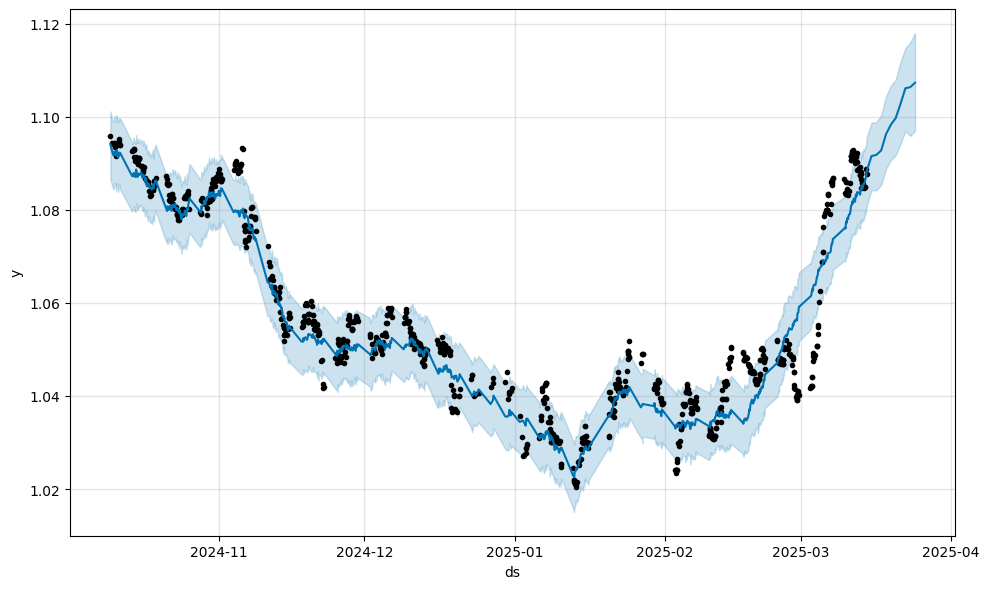

In [52]:
fig1 = prophet.plot(forecast)

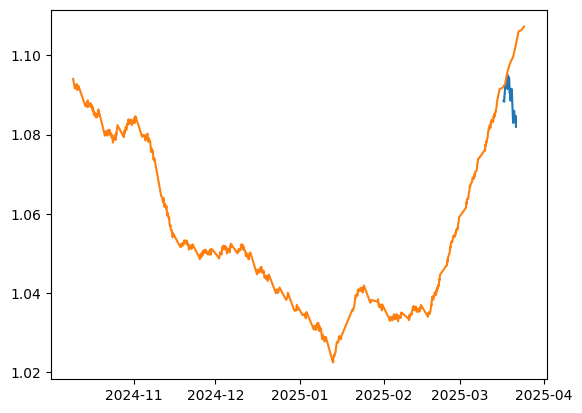

In [53]:
# Test data
plt.plot(
    test['ds'],
    test['y']
)
plt.plot(
    forecast['ds'],
    forecast['yhat']
)
plt.show()

In [ ]:
Lagged AutoRegressive Model -> Baseline 

SyntaxError: invalid syntax (3635961271.py, line 1)

# References: 

1. https://facebook.github.io/prophet/docs/quick_start.html#python-api (2025-03-22)